# XRF Digital Pulse Processor for spectral analysis

In this part of the project the main idea is to read the pulses, first of a known sample to calibrate the spectral lines, and then try to guess which materials are present in a unknown material dataset.


The datasets are present in the cloud folder:
- For the Cu:             /media/*argoXX*/smr3891/Project_2_Dataset/Cu.csv 
- For the unknown sample: /media/*argoXX*/smr3891/Project_2_Dataset/Sample.csv

So, the first task will be to download the databases for reading the data. 
Copy both databases in the same directory as this Jupyter Notebook



## Create the vivado project

As in the Project 1, the Vivado project is created with a tcl file.
This file is included into the *bd* directory of this Lab.

In Vivado, add the vhdl source files under the directory *vhdl* and, create the project for the Zedboard.

Don't forget to include the Comlock within the IPs (Settings --> IPs --> Repository) and then run the **xrf_dpp_block_design.tcl** command into the tcl terminal.


## Run the simulation for adjusting the DPP parameters

In this part you will have to adjust the DPP configuration parameters for detecting the pulses. (cf_1, cf_2, cf_3, det_threshold_high and det_threshold_low)

## Export the hardware and Launch Vitis

Once you generate the bitstream, export the hardware including the bitstream and launch the Vitis.

In this step, when opening the Vitis it will ask you to select the Workspace, be sure it is the same directory as the Vivado project.

Create an application process using the FreeRTOS with the udma template.



## Activities

Through the Comblock we will send the XRF pulses to the FIFO input, process the data with the DPP and at the end, generate an histogram of the pulses amplitude.

1) **Python**
  - Instantiate a UDMA object
  - Connect the UDMA object to the Zedboard
2) **Python + UDMA <---> Zynq SoC**
  - Complete the missing parts in the code denoted by ?? signs
  - Set up the DPP parameters
  - Send 8192 pulses
  - Read the pulses amplitude
3) **Python**
  - Generate the Histogram of the amplitudes values

- Author(s): Bruno Valinoti, Luis Garcia (MLab/ICTP)
- Update(s):

## Import Libraries, set up the connection parameters and connect to Zedboard

In [55]:
# == MLab library ==
import udma #MLab UDMA library
# Numpy
import numpy as np
# Pandas for data managing
import pandas as pd

# Bit manipulation library
from struct import pack, unpack

from time import sleep

In [56]:
IP_ADDRESS = '192.168.1.10' # Set your ZedBoard IP Address here
IP_PORT = 7

zedBoard = udma.UDMA_CLASS(IP_ADDRESS, IP_PORT)

In [57]:
connectionStatus = 0
while(connectionStatus == 0):
    connectionStatus = zedBoard.connect()
    sleep(1)

_ = zedBoard.log(0)

KeyboardInterrupt: 

In [36]:
## Set up DPP parameters

# Output registers
CB_DPP_ENA_REG		    = 0 # DPP Enable operation
CB_FIFO_CLR_REG		    = 1 # Comblock FIFO clear
CB_DPP_OP_MODE_REG      = 2 # DPP operation mode
CB_DPP_DET_TRSHLD_H_REG	= 3 # DPP detection threshold high (2500)
CB_DPP_DET_TRSHLD_L_REG = 4 # DPP detection threshold low  (30)
CB_DPP_DET_COEF_1_REG	= 5 # DPP detection short fir coef 1 (1)
CB_DPP_DET_COEF_2_REG	= 6 # DPP detection short fir coef 2 (3) 
CB_DPP_DET_COEF_3_REG	= 7 # DPP detection short fir coef 3 (5)

### Read the pulses and save it in a Panda dataframe

Note: This step may take several seconds ~25.0 s

<Axes: >

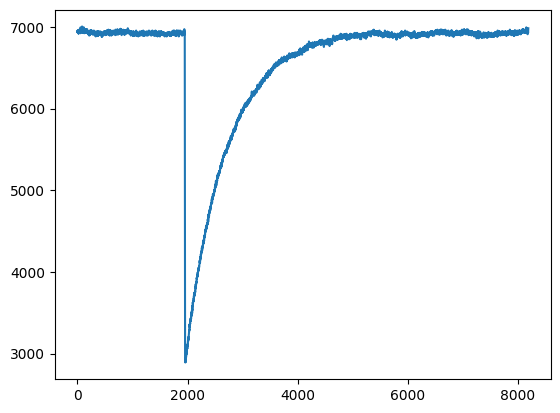

In [37]:
# Read the pulses and store them into a dataframe
df = pd.read_csv('Cu.csv', dtype= int)
# Plot a single pulse
df.iloc[:,1].plot()

### Set up the DPP parameters

In [38]:
# Clear input FIFO contents to get the latest data from the FIR filter output
zedBoard.write_reg(CB_DPP_ENA_REG, 0x00) # Disable DPP operation

# Set high and low threshold values
zedBoard.write_reg(CB_DPP_DET_TRSHLD_H_REG, 2000)   
zedBoard.write_reg(CB_DPP_DET_TRSHLD_L_REG, 30)

# Set operation mode
zedBoard.write_reg(CB_DPP_OP_MODE_REG, 0x01)

# Set short fir coefficients
zedBoard.write_reg(CB_DPP_DET_COEF_1_REG, 0x01)
zedBoard.write_reg(CB_DPP_DET_COEF_2_REG, 0x03)
zedBoard.write_reg(CB_DPP_DET_COEF_3_REG, 0x05)

# Reset all fifos
zedBoard.write_reg(CB_FIFO_CLR_REG, 0x00)
zedBoard.write_reg(CB_FIFO_CLR_REG, 0x01)
zedBoard.write_reg(CB_FIFO_CLR_REG, 0x00)

[(1, 0), 0]

## Write pulse data to comblock's FIFO
First, we will try with a single pulse to verify the DPP operation.

For each pulse we will need to:
1) Disable the operation of the DPP
2) Transfer the data to the FIFO
3) Enable operation 
4) Wait for 83 us (nothing)
5) Disable operation

### Disable the operation of the DPP

In [39]:
zedBoard.write_reg(CB_DPP_ENA_REG, 0x00)

[(1, 0), 0]

### Transfer the data to the FIFO

In [40]:
pulse = df.iloc[:,1].values
zedBoard.write_fifo(len(pulse),pulse)

[(1, 8191), 0]

### Enable operation

In [41]:
zedBoard.write_reg(CB_DPP_ENA_REG, 0x01)

[(1, 0), 0]

### Print data and disable operation

In [42]:
amp_value=zedBoard.read_fifo(1)[1]
print(amp_value[0])
zedBoard.write_reg(CB_DPP_ENA_REG, 0x00)

737


[(1, 0), 0]

### Process the whole Cu dataset

For each pulse we will need to:
1) Disable the operation of the DPP
2) Transfer the data to the FIFO
3) Enable operation 
4) Wait for 83 us (nothing)

Then, contiune with the previous sequence looping and, after the last data (8191) we have to disable the operation again.


In [53]:
# Reset all fifos 
zedBoard.write_reg(CB_FIFO_CLR_REG, 0x00)
zedBoard.write_reg(CB_FIFO_CLR_REG, 0x01)
zedBoard.write_reg(CB_FIFO_CLR_REG, 0x00)

# send all pulses to the DPP
for i in range(800):
    zedBoard.write_reg(CB_DPP_ENA_REG, 0x00)
    pulse = df.iloc[:,i].values
    pulse_splitted = np.array_split(pulse,8)
    for j ,piece in enumerate(pulse_splitted):
        zedBoard.write_fifo(len(piece),piece)
    zedBoard.write_reg(CB_DPP_ENA_REG, 0x01)
    print(i)
   # amp_value=zedBoard.read_fifo(1)[1]
   # print(amp_value)
    sleep(1.5)


KeyboardInterrupt: 

In [54]:
i

33

In [ ]:
amp_value=zedBoard.read_fifo(1)[1]

In [49]:
len(piece)

1024